In [1]:
import configparser
import numpy as np
from datetime import datetime
import pickle
import psycopg2

import pandas as pd
import geopandas as gpd
import psycopg2
from osgeo import gdal, gdal_array
from skimage.draw import polygon2mask
import matplotlib.pyplot as plt

from tathu.io import pgis
from tathu import visualizer
from tathu.utils import (
    extractPeriods,
    file2timestamp,
    getGeoT,
    geo2grid,
)
from tathu.geometry.transform import shapely2ogr
from tathu.geometry.utils import extractCoordinates
from tathu.constants import LAT_LON_WGS84
from tathu.io.pgis import bytea2nparray, _adapt_array

from read_sipam_cappis_cptec import read_simple_cappi

# Tell pgis how to deal with numpy arrays
psycopg2.extensions.register_adapter(np.ndarray, _adapt_array)

from my_secrets import postgis_pwd

In [20]:
# File paths
gld_path = "/home/camilacl/git/amazon-storms-aerosols/data/lightning/GLD_mod/"
radar_path = "/data2/GOAMAZON/radar/sipam_manaus/cptec_cappi/"
init_path = "/home/camilacl/git/amazon-storms-aerosols/data/general/"

# Load family
db = pgis.Loader(
    "localhost", "goamazon_geo", "postgres", "postgres", "systems_filtered"
)
# Get systems
names = db.loadNames()
# print(len(names))
# Get dates
dates = db.loadDates()
print(len(dates))

19199


### Fill classification

In [3]:
f = db.load(names[0], ['gld'])
np.sum([x for x in [None, None] if x is not None])

0.0

In [3]:
for name in names[:5]:
    fam = db.load(
        name, ["count", "max", "event"]
    )
    # Getting data
    timestamps = fam.getTimestamps()
    events = fam.getAttribute("event")
    max_area = np.max(fam.getAttribute("count"))
    max_z = np.max(fam.getAttribute("max"))
    duration = timestamps[-1] - timestamps[0]
    init_ts = timestamps[0]
    print(init_ts)
    
    if max_area <= 1000:
        clf_area = 'small'
    else:
        clf_area = 'large'
    
    if max_z >= 55:
        clf_z = 'intense'
    else:
        clf_z = 'no_intense'
    
    if ('SPLIT' in events) | ('MERGE' in events):
        clf_life = 'with_splitmerge'
    else:
        clf_life = 'no_splitmerge'
    
    if duration.total_seconds() <= 3600:
        clf_duration = 'short_span'
    elif (duration.total_seconds() > 3600) & (duration.total_seconds() <= 3600*3):
        clf_duration = "medium_span"
    else:
        clf_duration = 'large_span'
        
    if init_ts.month in [1,2,3]:
        clf_season = 'wet'
    elif init_ts.month in [8, 9, 10]:
        clf_season = 'dry'
    elif init_ts.month in [11, 12]:
        clf_season = 'dry-to-wet'
    else:
        clf_season = ''
    
    if init_ts.hour in [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]:
        clf_timeofday = 'diurnal'
    else:
        clf_timeofday = 'nocturnal'
    
    print(duration)
    print(events)
    print(clf_life)
    print(clf_duration)
    print(clf_season)
    print(clf_timeofday)

2015-11-26 05:12:00
0:36:00
['SPONTANEOUS_GENERATION', 'SPLIT', 'MERGE', 'CONTINUITY']
with_splitmerge
short_span
dry-to-wet
nocturnal
2015-12-17 18:36:00
0:12:00
['SPONTANEOUS_GENERATION', 'CONTINUITY']
no_splitmerge
short_span
dry-to-wet
nocturnal
2014-06-12 18:48:00
1:00:00
['SPONTANEOUS_GENERATION', 'CONTINUITY', 'CONTINUITY', 'MERGE', 'CONTINUITY', 'SPLIT']
with_splitmerge
short_span

nocturnal
2015-11-23 15:48:00
0:12:00
['SPONTANEOUS_GENERATION', 'CONTINUITY']
no_splitmerge
short_span
dry-to-wet
diurnal
2014-11-12 14:00:00
0:48:00
['SPONTANEOUS_GENERATION', 'CONTINUITY', 'SPLIT', 'MERGE', 'CONTINUITY']
with_splitmerge
short_span
dry-to-wet
diurnal


## Systems 25 km

### Correlations

In [21]:
# -- CS name, duration
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]

# -- Single params
query = (
    "SELECT DISTINCT ON (name) date_init25, totaerosol25_1_cm3, totccn25_1_cm3,"
    " cape25_j_kg, cin25_j_kg, blrh25_pc, lvws25_m_s, ufaerosol25_1_cm3, wcd25_km FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
date_init = [q[0] for q in db.query(query)]
totaerosol = [q[1] for q in db.query(query)]
totccn = [q[2] for q in db.query(query)]
cape = [q[3] for q in db.query(query)]
cin = [q[4] for q in db.query(query)]
blrh = [q[5] for q in db.query(query)]
lvws = [q[6] for q in db.query(query)]
ufaerosol = [q[7] for q in db.query(query)]
wcd = [q[8] for q in db.query(query)]

# -- Max, sum params
query = (
    "SELECT MAX(count), MAX(max), MAX(echotop_0), MAX(echotop_20),"
    " MAX(echotop_40), MAX(maxvil_kgm2), MAX(maxvii_kgm2), MAX(maxviwl_kgm2) FROM systems_filtered"
    " GROUP BY name ORDER BY name ASC"
)
maxarea = [q[0] for q in db.query(query)]
maxz = [q[1] for q in db.query(query)]
maxecho0 = [q[2] for q in db.query(query)]
maxecho20 = [q[3] for q in db.query(query)]
maxecho40 = [q[4] for q in db.query(query)]
maxvil = [q[5] for q in db.query(query)]
maxvii = [q[6] for q in db.query(query)]
maxviwl = [q[7] for q in db.query(query)]

query = "SELECT SUM(gld) FROM systems_filtered GROUP BY name ORDER BY name ASC"
gld = [q[0] for q in db.query(query)]

# -- Classifications
query = (
    "SELECT DISTINCT ON (name) clf_area, clf_z, clf_life, clf_duration,"
    " clf_season, clf_timeofday, clf_lightning FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
clf_area = [q[0] for q in db.query(query)]
clf_z = [q[1] for q in db.query(query)]
clf_life = [q[2] for q in db.query(query)]
clf_duration = [q[3] for q in db.query(query)]
clf_season = [q[4] for q in db.query(query)]
clf_timeofday = [q[5] for q in db.query(query)]
clf_lightning = [q[6] for q in db.query(query)]

In [22]:
systems = pd.DataFrame(
    {
        'name': names,
        'duration': [float(d) for d in durations],
        'date_init': date_init,
        'max_area': maxarea,
        'max_z': maxz,
        'max_echotop0': maxecho0,
        'max_echotop20': maxecho20,
        'max_echotop40': maxecho40,
        'gld': gld,
        'totaerosol': totaerosol,
        'ufaerosol': ufaerosol,
        'totccn': totccn,
        'cape': cape,
        'cin': cin,
        'blrh': blrh,
        'lvws': lvws,
        'wcd': wcd,
        'max_vil': maxvil,
        'max_vii': maxvii,
        'max_viwl': maxviwl,
        'clf_area': clf_area,
        'clf_z': clf_z,
        'clf_life': clf_life,
        'clf_duration': clf_duration,
        'clf_season': clf_season,
        'clf_timeofday': clf_timeofday,
        'clf_lightning': clf_lightning,
    }
).set_index('name').replace(r'^\s*$', np.nan, regex=True)
systems['hour_init'] = systems.date_init.dt.hour
systems['month_init'] = systems.date_init.dt.month

In [23]:
systems = systems.reindex(
    columns=['duration', 'date_init', 'hour_init', 'month_init', 'max_area', 
             'max_z', 'max_echotop0', 'max_echotop20', 'max_echotop40', 'gld',
             'totaerosol', 'ufaerosol', 'totccn', 'cape', 'cin', 'blrh', 'lvws', 
             'wcd', 'max_vil', 'max_vii', 'max_viwl', 'clf_area', 'clf_z', 'clf_life', 
             'clf_duration', 'clf_season', 'clf_timeofday', 'clf_lightning']
    )
systems.columns = [
    'duration', 
    'date_init', 
    'init hour', 
    'init month', 
    'max area', 
    'max reflectivity', 
    'max echotop 0 dBZ', 
    'max echotop 20 dBZ', 
    'max echotop 40 dBZ', 
    'GLD strokes',
    'total aerosols', 
    'ultrafine aerosols', 
    'total CCNs', 
    'CAPE', 
    'CIN', 
    'bl relative humidity', 
    'v-wind shear', 
    'warm cloud depth',
    'max VIL', 
    'max VII', 
    'max VIWL',
    'area', 
    'reflectivity', 
    'lifespan', 
    'sys duration', 
    'season', 
    'time of day',
    'electrical activity'
]
systems = systems[
        [
            'date_init', 
            'duration', 
            'sys duration', 
            'init hour', 
            'time of day',
            'init month', 
            'season', 
            'max area', 
            'area', 
            'lifespan', 
            'max reflectivity', 
            'reflectivity', 
            'max echotop 0 dBZ', 
            'max echotop 20 dBZ', 
            'max echotop 40 dBZ', 
            'max VIL', 
            'max VII', 
            'max VIWL',
            'GLD strokes',
            'electrical activity',
            'CAPE', 
            'CIN', 
            'bl relative humidity', 
            'v-wind shear', 
            'warm cloud depth',
            'total aerosols', 
            'ultrafine aerosols', 
            'total CCNs', 
        ]
    ]

In [27]:
systems.dropna().loc['7c628bc5-ad2c-4454-a6f4-092ed05cf9ab']

KeyError: '7c628bc5-ad2c-4454-a6f4-092ed05cf9ab'

In [28]:
systems.dropna().describe()

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,max VIL,max VII,max VIWL,GLD strokes,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,total aerosols,ultrafine aerosols,total CCNs
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,72.279070,10.767442,5.759690,670.906977,53.543954,13.534884,12.248062,6.891473,0.294986,0.188053,0.179921,97.325581,2352.613900,-21.577640,82.574357,-1.908904,4.248537,1792.140149,696.582163,667.873793
std,70.746353,8.023901,3.993697,709.716046,2.540728,1.854246,2.407771,1.929379,0.057743,0.072357,0.011961,290.747828,1581.512654,33.652881,9.119135,3.458863,0.471348,1549.837046,692.810492,715.311149
min,0.000000,0.000000,1.000000,110.000000,46.920000,7.000000,6.000000,4.000000,0.141964,0.000000,0.141964,0.000000,-30.380970,-155.760930,61.481230,-9.761905,2.458601,115.719710,24.492088,0.000000
25%,24.000000,5.000000,2.000000,270.000000,51.940000,13.000000,10.000000,6.000000,0.254854,0.137542,0.172725,1.000000,1218.370200,-40.998950,76.096954,-4.215829,4.111190,817.285770,212.779710,199.734830
50%,48.000000,8.000000,3.000000,418.000000,53.580000,14.000000,13.000000,6.000000,0.298040,0.203376,0.181646,10.000000,2077.611300,-0.705408,82.989840,-2.156434,4.350689,1357.052500,399.681920,465.319400
75%,108.000000,19.000000,9.000000,768.000000,55.110000,15.000000,15.000000,8.000000,0.342652,0.242776,0.188462,53.000000,3547.216600,0.000000,90.020744,-0.416496,4.538934,2474.943000,984.286700,892.475600
max,492.000000,23.000000,12.000000,4287.000000,61.379993,15.000000,15.000000,15.000000,0.440078,0.341767,0.214249,2668.000000,6351.676000,0.000000,99.871080,11.422686,5.211758,9882.648000,3106.461200,4732.545400


In [16]:
systems.dropna().corr()

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,max VIL,max VII,max VIWL,GLD strokes,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,total aerosols,ultrafine aerosols,total CCNs
duration,1.000000,-0.073916,-0.027051,0.137288,0.028516,0.018310,0.063332,0.078092,0.073975,0.041193,0.081470,-0.021971,0.071967,-0.034516,-0.080034,-0.025457,0.073425,-0.016061,-0.061387,-0.011158
init hour,-0.073916,1.000000,-0.054174,0.027984,-0.003227,-0.057736,-0.113048,0.000376,-0.054462,-0.066043,-0.022132,0.107817,0.353574,0.332412,-0.186831,0.089033,-0.320117,0.044228,0.157533,0.008976
init month,-0.027051,-0.054174,1.000000,-0.139461,0.124232,-0.047916,-0.020563,0.287580,0.161403,0.049862,0.316602,0.126094,-0.001278,-0.170939,-0.340663,-0.092418,-0.126927,0.214946,-0.009794,0.418485
max area,0.137288,0.027984,-0.139461,1.000000,0.117451,0.233020,0.299629,0.196539,0.323880,0.334013,0.178830,0.283032,0.015083,0.099184,-0.011218,0.099982,0.033724,-0.018483,0.058359,-0.100699
max reflectivity,0.028516,-0.003227,0.124232,0.117451,1.000000,0.088217,0.224399,0.518624,0.293424,0.214655,0.542828,0.363185,0.132509,-0.167408,-0.247432,0.054629,-0.000536,0.254525,0.201150,0.223345
max echotop 0 dBZ,0.018310,-0.057736,-0.047916,0.233020,0.088217,1.000000,0.878235,0.429084,0.832600,0.914840,0.542768,0.187351,0.024141,0.005476,-0.046781,0.162448,0.204209,0.000096,0.007056,-0.033282
max echotop 20 dBZ,0.063332,-0.113048,-0.020563,0.299629,0.224399,0.878235,1.000000,0.552404,0.917055,0.933070,0.646608,0.247019,0.077563,0.036347,-0.102109,0.210572,0.192007,0.038028,0.000108,0.021059
max echotop 40 dBZ,0.078092,0.000376,0.287580,0.196539,0.518624,0.429084,0.552404,1.000000,0.707036,0.616573,0.809992,0.582238,0.084451,-0.114230,-0.320981,-0.022717,0.012844,0.334453,0.151817,0.388221
max VIL,0.073975,-0.054462,0.161403,0.323880,0.293424,0.832600,0.917055,0.707036,1.000000,0.959514,0.778974,0.371327,0.071535,-0.014260,-0.225485,0.125581,0.088112,0.163707,0.058213,0.182941
max VII,0.041193,-0.066043,0.049862,0.334013,0.214655,0.914840,0.933070,0.616573,0.959514,1.000000,0.662965,0.309684,0.063566,0.029469,-0.151174,0.140118,0.135800,0.106400,0.039156,0.096923


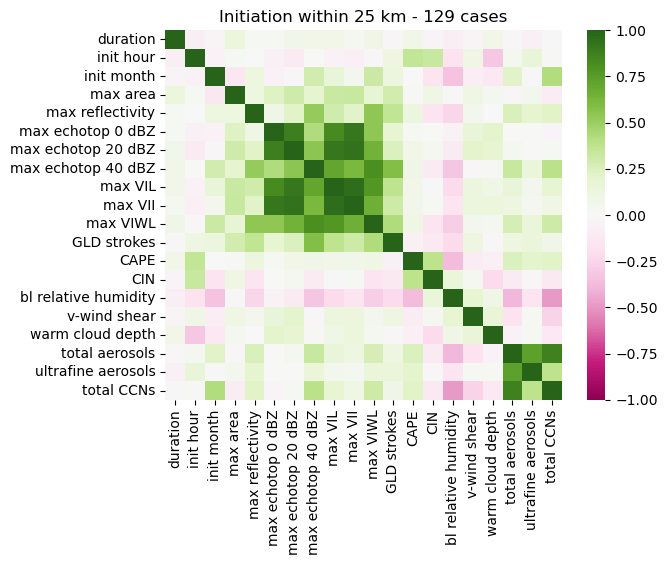

In [17]:
import seaborn as sns

sns.heatmap(systems.dropna().corr(), vmin=-1, vmax=1, cmap='PiYG').set_title("Initiation within 25 km - " + str(systems.dropna().shape[0]) + " cases")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_map_init25.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)


In [9]:
systems.columns

Index(['duration', 'date_init', 'init hour', 'init month', 'max area',
       'max reflectivity', 'max echotop 0 dBZ', 'max echotop 20 dBZ',
       'max echotop 40 dBZ', 'GLD strokes', 'total aerosols',
       'ultrafine aerosols', 'total CCNs', 'CAPE', 'CIN',
       'bl relative humidity', 'v-wind shear', 'max VIL', 'max VII', 'area',
       'reflectivity', 'lifespan', 'sys duration', 'season', 'time of day',
       'electrical activity'],
      dtype='object')

In [29]:
systems.to_csv('/home/camilacl/git/amazon-storms-aerosols/data/general/systems_filtered_25km.csv')

### Outros gráficos

<AxesSubplot:xlabel='total aerosols', ylabel='max reflectivity'>

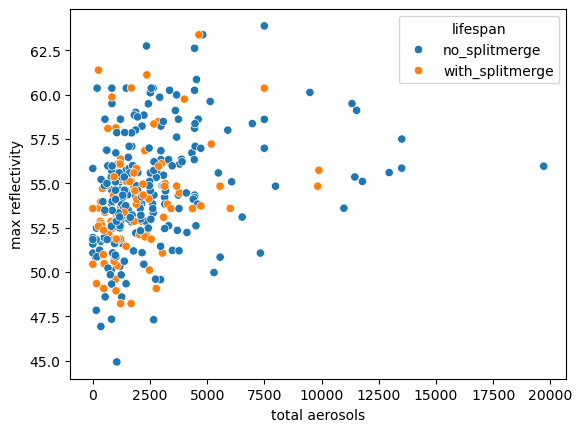

In [47]:
sns.scatterplot(data=systems, x="total aerosols", y="max reflectivity", hue="lifespan")

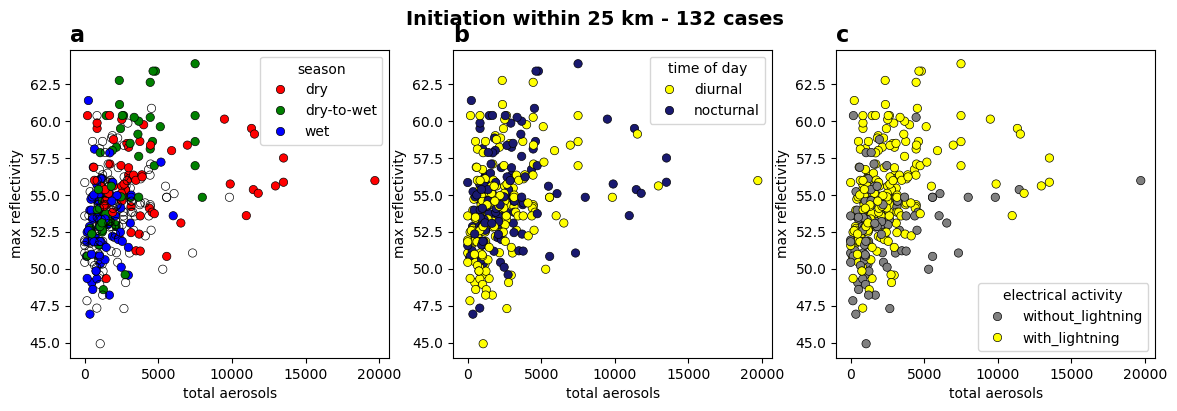

In [57]:
fig, axs = plt.subplots(figsize=(14,4), ncols=3)
season_order = ['dry', 'dry-to-wet', 'wet']

sns.scatterplot(data=systems, x="total aerosols", y="max reflectivity", hue="season", palette=['red','green', 'blue'], hue_order=season_order, edgecolor="black", ax=axs[0])
sns.scatterplot(data=systems, x="total aerosols", y="max reflectivity", hue="time of day", palette=['yellow','midnightblue'], edgecolor="black", ax=axs[1])
sns.scatterplot(data=systems, x="total aerosols", y="max reflectivity", hue="electrical activity", palette=["gray", "yellow"], edgecolor="black", ax=axs[2])
fig.suptitle("Initiation within 25 km - " + str(systems.dropna().shape[0]) + " cases", size=14, fontweight="bold")
axs[0].set_title("a", loc="left", fontweight="bold", size=16)
axs[1].set_title("b", loc="left", fontweight="bold", size=16)
axs[2].set_title("c", loc="left", fontweight="bold", size=16)
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_test_init25.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

## Systems 10 km

In [2]:
# File paths
gld_path = "/home/camilacl/git/amazon-storms-aerosols/data/lightning/GLD_mod/"
radar_path = "/data2/GOAMAZON/radar/sipam_manaus/cptec_cappi/"
init_path = "/home/camilacl/git/amazon-storms-aerosols/data/general/"

# Load family
db = pgis.Loader(
    "localhost", "goamazon_geo", "postgres", "postgres", "systems_filtered"
)
# Get systems
names = db.loadNames()
# print(len(names))
# Get dates
dates = db.loadDates()
print(len(dates))

19199


In [3]:
# -- CS name, duration
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]

# -- Single params
query = (
    "SELECT DISTINCT ON (name) date_init10, totaerosol10_1_cm3, totccn10_1_cm3,"
    " cape10_j_kg, cin10_j_kg, blrh10_pc, lvws10_m_s, ufaerosol10_1_cm3, wcd10_km FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
date_init = [q[0] for q in db.query(query)]
totaerosol = [q[1] for q in db.query(query)]
totccn = [q[2] for q in db.query(query)]
cape = [q[3] for q in db.query(query)]
cin = [q[4] for q in db.query(query)]
blrh = [q[5] for q in db.query(query)]
lvws = [q[6] for q in db.query(query)]
ufaerosol = [q[7] for q in db.query(query)]
wcd = [q[8] for q in db.query(query)]

# -- Max, sum params
query = (
    "SELECT MAX(count), MAX(max), MAX(echotop_0), MAX(echotop_20),"
    " MAX(echotop_40), MAX(maxvil_kgm2), MAX(maxvii_kgm2), MAX(maxviwl_kgm2) FROM systems_filtered"
    " GROUP BY name ORDER BY name ASC"
)
maxarea = [q[0] for q in db.query(query)]
maxz = [q[1] for q in db.query(query)]
maxecho0 = [q[2] for q in db.query(query)]
maxecho20 = [q[3] for q in db.query(query)]
maxecho40 = [q[4] for q in db.query(query)]
maxvil = [q[5] for q in db.query(query)]
maxvii = [q[6] for q in db.query(query)]
maxviwl = [q[7] for q in db.query(query)]

query = "SELECT SUM(gld) FROM systems_filtered GROUP BY name ORDER BY name ASC"
gld = [q[0] for q in db.query(query)]

# -- Classifications
query = (
    "SELECT DISTINCT ON (name) clf_area, clf_z, clf_life, clf_duration,"
    " clf_season, clf_timeofday, clf_lightning FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
clf_area = [q[0] for q in db.query(query)]
clf_z = [q[1] for q in db.query(query)]
clf_life = [q[2] for q in db.query(query)]
clf_duration = [q[3] for q in db.query(query)]
clf_season = [q[4] for q in db.query(query)]
clf_timeofday = [q[5] for q in db.query(query)]
clf_lightning = [q[6] for q in db.query(query)]

In [12]:
systems_10 = pd.DataFrame(
    {
        'name': names,
        'duration': [float(d) for d in durations],
        'date_init': date_init,
        'max_area': maxarea,
        'max_z': maxz,
        'max_echotop0': maxecho0,
        'max_echotop20': maxecho20,
        'max_echotop40': maxecho40,
        'gld': gld,
        'totaerosol': totaerosol,
        'ufaerosol': ufaerosol,
        'totccn': totccn,
        'cape': cape,
        'cin': cin,
        'blrh': blrh,
        'lvws': lvws,
        'wcd': wcd,
        'max_vil': maxvil,
        'max_vii': maxvii,
        'max_viwl': maxvil,
        'clf_area': clf_area,
        'clf_z': clf_z,
        'clf_life': clf_life,
        'clf_duration': clf_duration,
        'clf_season': clf_season,
        'clf_timeofday': clf_timeofday,
        'clf_lightning': clf_lightning,
    }
).set_index('name').replace(r'^\s*$', np.nan, regex=True)
systems_10['hour_init'] = systems_10.date_init.dt.hour
systems_10['month_init'] = systems_10.date_init.dt.month

In [13]:
systems_10 = systems_10.reindex(
    columns=['duration', 'date_init', 'hour_init', 'month_init', 'max_area', 
             'max_z', 'max_echotop0', 'max_echotop20', 'max_echotop40', 'gld',
             'totaerosol', 'ufaerosol', 'totccn', 'cape', 'cin', 'blrh', 'lvws', 
             'wcd', 'max_vil', 'max_vii', 'max_viwl', 'clf_area', 'clf_z', 'clf_life', 
             'clf_duration', 'clf_season', 'clf_timeofday', 'clf_lightning']
    )
systems_10.columns = [
    'duration', 
    'date_init', 
    'init hour', 
    'init month', 
    'max area', 
    'max reflectivity', 
    'max echotop 0 dBZ', 
    'max echotop 20 dBZ', 
    'max echotop 40 dBZ', 
    'GLD strokes',
    'total aerosols', 
    'ultrafine aerosols', 
    'total CCNs', 
    'CAPE', 
    'CIN', 
    'bl relative humidity', 
    'v-wind shear', 
    'warm cloud depth',
    'max VIL', 
    'max VII', 
    'max VIWL',
    'area', 
    'reflectivity', 
    'lifespan', 
    'sys duration', 
    'season', 
    'time of day',
    'electrical activity'
]
systems_10 = systems_10[
    [
        'date_init', 
        'duration', 
        'sys duration', 
        'init hour', 
        'time of day',
        'init month', 
        'season', 
        'max area', 
        'area', 
        'lifespan', 
        'max reflectivity', 
        'reflectivity', 
        'max echotop 0 dBZ', 
        'max echotop 20 dBZ', 
        'max echotop 40 dBZ', 
        'max VIL', 
        'max VII', 
        'max VIWL',
        'GLD strokes',
        'electrical activity',
        'CAPE', 
        'CIN', 
        'bl relative humidity', 
        'v-wind shear', 
        'warm cloud depth',
        'total aerosols', 
        'ultrafine aerosols', 
        'total CCNs', 
    ]
]

In [15]:
systems_10.dropna().describe()

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,max VIL,max VII,max VIWL,GLD strokes,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,total aerosols,ultrafine aerosols,total CCNs
count,74.000000,74.000000,74.00000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,74.270270,11.337838,6.27027,665.472973,54.023109,13.810811,12.459459,7.094595,0.307706,0.204707,0.307706,161.635135,2295.020008,-29.647675,81.877446,-1.349916,4.227257,1793.474267,667.507372,662.113492
std,68.046982,7.687879,3.92148,581.883179,2.476686,1.810742,2.559908,2.258433,0.061654,0.075651,0.061654,495.549745,1619.129746,44.035907,9.585170,3.747806,0.486127,1641.960464,741.091232,618.654157
min,0.000000,0.000000,1.00000,108.000000,48.210000,8.000000,5.000000,4.000000,0.161177,0.000000,0.161177,0.000000,-30.380970,-185.032380,61.481230,-9.552803,2.458601,168.498080,29.084630,0.000000
25%,24.000000,6.000000,3.00000,278.500000,52.350000,13.000000,11.000000,6.000000,0.261314,0.170221,0.261314,1.000000,1066.781875,-46.803505,75.424090,-4.012412,4.089682,621.288115,192.810608,215.673560
50%,48.000000,11.500000,8.00000,499.000000,53.965000,15.000000,13.000000,7.000000,0.325966,0.234169,0.325966,13.000000,2150.770400,-0.980755,80.564822,-1.775218,4.350689,1287.181350,302.971460,477.411925
75%,120.000000,19.000000,10.00000,806.250000,55.602500,15.000000,15.000000,8.000000,0.350755,0.251649,0.350755,92.250000,3530.510900,0.000000,89.179622,0.528151,4.520042,2356.813425,906.400775,931.748275
max,300.000000,23.000000,12.00000,3674.000000,60.120003,15.000000,15.000000,15.000000,0.440078,0.341767,0.440078,3129.000000,6351.676000,0.000000,99.623870,9.961557,5.211758,9489.316000,3141.172600,3663.577100


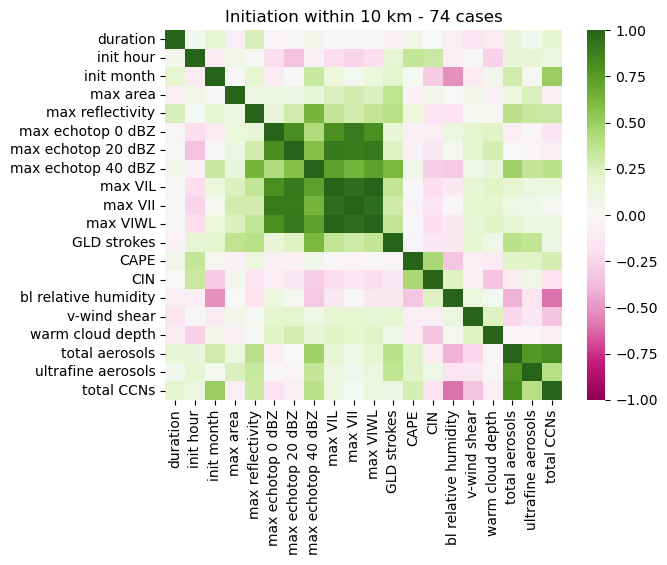

In [16]:
import seaborn as sns

sns.heatmap(systems_10.dropna().corr(), vmin=-1, vmax=1, cmap='PiYG').set_title("Initiation within 10 km - " + str(systems_10.dropna().shape[0]) + " cases")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_map_init10.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

In [17]:
systems_10.to_csv('/home/camilacl/git/amazon-storms-aerosols/data/general/systems_filtered_10km.csv')

In [18]:
systems_10.corr()

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,max VIL,max VII,max VIWL,GLD strokes,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,total aerosols,ultrafine aerosols,total CCNs
duration,1.000000,0.043521,0.189757,0.031618,-0.001229,0.034618,0.037905,-0.001227,0.028023,0.032174,0.028023,0.011147,0.180759,0.020142,-0.139538,-0.062324,-0.033376,0.189997,0.025915,0.199622
init hour,0.043521,1.000000,-0.097121,0.054963,-0.034237,-0.045211,-0.158470,-0.056443,-0.086283,-0.092568,-0.086283,-0.015654,0.256774,0.349253,-0.027750,-0.036598,-0.387284,-0.147240,-0.103468,0.059749
init month,0.189757,-0.097121,1.000000,-0.099471,0.420605,0.089759,0.203556,0.488520,0.333905,0.238667,0.333905,0.186460,0.136620,-0.195068,-0.498741,-0.029991,-0.030980,0.455950,0.011326,0.524938
max area,0.031618,0.054963,-0.099471,1.000000,0.030742,0.182139,0.171781,0.075273,0.137227,0.183717,0.137227,0.240226,-0.071800,0.011395,0.095121,0.002808,-0.040812,-0.136066,0.036805,-0.070044
max reflectivity,-0.001229,-0.034237,0.420605,0.030742,1.000000,0.145182,0.232091,0.526400,0.346723,0.270922,0.346723,0.247524,0.233630,-0.045751,-0.358656,-0.017186,-0.043015,0.410447,0.186841,0.323056
max echotop 0 dBZ,0.034618,-0.045211,0.089759,0.182139,0.145182,1.000000,0.876147,0.470622,0.838780,0.903919,0.838780,0.168859,0.050757,-0.170247,-0.115965,0.161934,0.039686,0.106918,-0.151235,0.007649
max echotop 20 dBZ,0.037905,-0.158470,0.203556,0.171781,0.232091,0.876147,1.000000,0.610143,0.915578,0.925188,0.915578,0.222754,0.036233,-0.202608,-0.167884,0.146193,0.062084,0.212092,-0.090945,0.061064
max echotop 40 dBZ,-0.001227,-0.056443,0.488520,0.075273,0.526400,0.470622,0.610143,1.000000,0.759200,0.658635,0.759200,0.416331,0.227438,-0.168734,-0.416022,0.017750,-0.013324,0.475692,0.105668,0.432363
max VIL,0.028023,-0.086283,0.333905,0.137227,0.346723,0.838780,0.915578,0.759200,1.000000,0.950765,1.000000,0.299142,0.117349,-0.187679,-0.281796,0.115511,0.006292,0.311754,-0.057899,0.227093
max VII,0.032174,-0.092568,0.238667,0.183717,0.270922,0.903919,0.925188,0.658635,0.950765,1.000000,0.950765,0.281797,0.081543,-0.184728,-0.205410,0.133640,0.018018,0.234114,-0.096168,0.141910


### Other figs

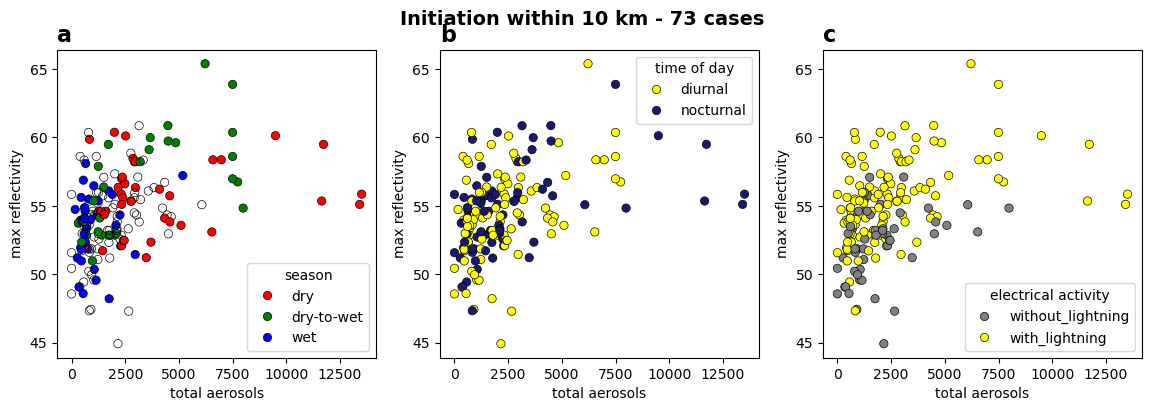

In [56]:
fig, axs = plt.subplots(figsize=(14,4), ncols=3)
season_order = ['dry', 'dry-to-wet', 'wet']

sns.scatterplot(data=systems_10, x="total aerosols", y="max reflectivity", hue="season", palette=['red','green', 'blue'], hue_order=season_order, edgecolor="black", ax=axs[0])
sns.scatterplot(data=systems_10, x="total aerosols", y="max reflectivity", hue="time of day", palette=['yellow','midnightblue'], edgecolor="black", ax=axs[1])
sns.scatterplot(data=systems_10, x="total aerosols", y="max reflectivity", hue="electrical activity", palette=["gray", "yellow"], edgecolor="black", ax=axs[2])
axs[0].set_title("a", loc="left", fontweight="bold", size=16)
axs[1].set_title("b", loc="left", fontweight="bold", size=16)
axs[2].set_title("c", loc="left", fontweight="bold", size=16)
fig.suptitle("Initiation within 10 km - " + str(systems_10.dropna().shape[0]) + " cases", size=14, fontweight="bold")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_test_init10.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

In [ ]:
# -- CS name, duration
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]
# -- CS Max area
query = "SELECT MAX(count) FROM systems_filtered GROUP BY name"
maxplots = [q[0] for q in db.query(query)]
# -- Cl max Z
query = "SELECT max FROM systems_filtered ORDER BY name, date_time ASC"
zmax = [q[0] for q in db.query(query)]
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
gld = [q[0] for q in db.query(query)]

# -- Classifications
query = (
    "SELECT DISTINCT ON (name) clf_area, clf_z, clf_life, clf_duration,"
    " clf_season, clf_timeofday, clf_lightning FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
clf_area = [q[0] for q in db.query(query)]
clf_z = [q[1] for q in db.query(query)]
clf_life = [q[2] for q in db.query(query)]
clf_duration = [q[3] for q in db.query(query)]
clf_season = [q[4] for q in db.query(query)]
clf_timeofday = [q[5] for q in db.query(query)]
clf_lightning = [q[6] for q in db.query(query)]

In [ ]:
systems = pd.DataFrame(
    {
        'name': names,
        'clf_area': clf_area,
        'clf_z': clf_z,
        'clf_life': clf_life,
        'clf_duration': clf_duration,
        'clf_season': clf_season,
        'clf_timeofday': clf_timeofday,
        'clf_lightning': clf_lightning,
        'totaerosol': totaerosol,
    }
).dropna(subset=["totaerosol"]).drop(columns=['totaerosol']).set_index('name')

In [ ]:
systems

In [ ]:
type(systems.clf_season[2])

In [ ]:
systems.corr()